In [233]:
import numpy as np
import pandas as pd
from Evaluator import ModelEvaluator
import torch
import random
from matplotlib import pylab as plt
from IPython.display import clear_output
import copy

In [234]:
data=pd.read_csv('datasets/malicious_data_generated.csv')
npdata=data.to_numpy()
malData=np.copy(npdata)
print(type(malData[1,:]))
print(malData[:1].shape)

<class 'numpy.ndarray'>
(1, 10)


## control

In [235]:
totalEpochs=1000
totalNumAdversarialData=500
saveValue=totalEpochs-totalNumAdversarialData
if saveValue<=0:
    saveValue=0
totalItemsConv=0

In [236]:
features=['A','B','C','D','F','G','H','I','j','k']
df=pd.DataFrame(columns=features)

In [237]:
class MalwareEnv():
    def __init__(self,totalEpochs):
        # Actions we can take, decrease, increse
        self.action_space = 20  
        # Set start 
        self.state = np.asarray(malData[random.randint(0,498),:])
        #model to evaluate the reward
        self.evaluator=ModelEvaluator()
        #units to move
        self.block=10
        #number of items saved
        self.savedItems=0
        #pointcritic
        self.pointCritic=totalEpochs-totalNumAdversarialData
        #loss
        self.hit=0
        
    def reset(self):
        self.state = np.asarray(malData[random.randint(0,498),:])
        
        
    def step(self, action):
        
        if(action<9):
            self.state[action]+=self.block
        elif(action>=9 and action<19):
            self.state[action-9]-=self.block
            
        
    def reward(self):
        reward=-1
        value=self.state.tolist()
        result=self.evaluator.test(value)
        result=np.array2string(result)
        
        if(result=="['benign']"):
            self.hit+=1
            reward=+10
            self.saveItem()
                 
        return reward    
    
    def saveItem(self):
        
        
        if self.hit>self.pointCritic:
            
            print("saveddddddddddddddddddddddddddddddddddd")
            
            formatier=self.state.reshape(1,-1)[0]
            df.loc[self.savedItems]=formatier
            self.savedItems+=1
            

    def render_np(self):
        return self.state
    

In [238]:
totalItemsSaved

0

In [239]:


l1 = 10
l2 = 24
l3 = 72
l4 = 20
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
#device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.cuda()
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
gamma = 0.9
epsilon = 1.0

In [240]:
epochs = copy.copy(totalEpochs)
losses = [] 
env = MalwareEnv(totalEpochs)


for i in range(epochs): 
    env.reset()
    state_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0 
    state1 = torch.from_numpy(state_).float() 
    status = 1 
    while(status == 1): 
        qval = model(state1.cuda()) 
        qval_ = qval.data.cpu().numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,20)
        else:
            action_ = np.argmax(qval_)
        
        env.step(action_) 
        state2_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0
        state2 = torch.from_numpy(state2_).float() 
        reward = env.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,10).cuda())
        maxQ = torch.max(newQ) 
        if reward == -1: 
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] 
        loss = loss_fn(X.cuda(), Y.cuda()) 
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: 
            status = 0
    if epsilon > 0.1: 
        epsilon -= (1/epochs)

saveddddddddddddddddddddddddddddddddddd
999 11.163313865661621


D:\programas\anaco\envs\latest tf 101021\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [241]:
losses
#clear_output(wait=True)

[15.470991134643555,
 128.3486785888672,
 12.42286205291748,
 17.2730712890625,
 209.43936157226562,
 56.869144439697266,
 98.53559875488281,
 6.100376129150391,
 2.483839750289917,
 0.8795545697212219,
 231.88816833496094,
 237.79563903808594,
 0.8116059899330139,
 373.8893127441406,
 77.19566345214844,
 54.31175231933594,
 295.8298034667969,
 15.416839599609375,
 8.662272453308105,
 15.450918197631836,
 98.1783447265625,
 6.171165466308594,
 0.1692490428686142,
 132.60853576660156,
 0.09755554050207138,
 24.05514907836914,
 24.381759643554688,
 0.9855945706367493,
 70.88898468017578,
 0.16174258291721344,
 0.02148282527923584,
 262.41363525390625,
 1.3172800540924072,
 4.957935333251953,
 170.3876953125,
 0.008119952864944935,
 1.518471121788025,
 12.100284576416016,
 0.42662838101387024,
 2.837393283843994,
 10.170243263244629,
 73.797607421875,
 77.32938385009766,
 0.21640744805335999,
 61.87299728393555,
 27.00669288635254,
 23.59164810180664,
 14.635602951049805,
 17.649986267089

Text(0, 0.5, 'Loss')

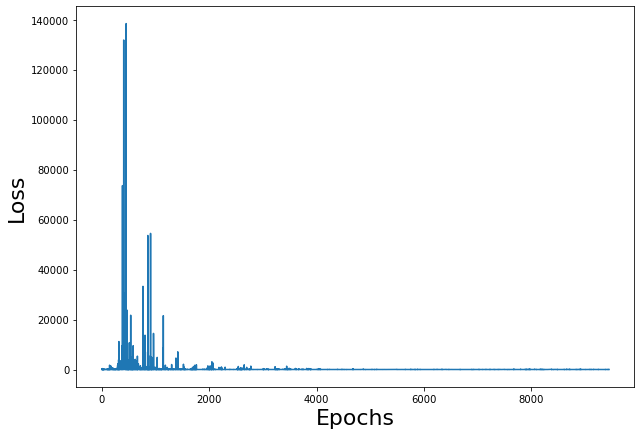

In [242]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [243]:
df

,A,B,C,D,F,G,H,I,j,k
0,-97.0,-47.0,-6.0,-27.0,73.0,13.0,-59.0,93.0,-36.0,5.0
1,-1.0,-65.0,-26.0,51.0,-9.0,23.0,63.0,-54.0,19.0,15.0
2,-1.0,63.0,-93.0,43.0,-12.0,76.0,-4.0,-53.0,62.0,50.0
3,53.0,-25.0,42.0,87.0,1.0,1.0,18.0,-6.0,83.0,11.0
4,-79.0,-62.0,-21.0,83.0,0.0,46.0,-52.0,13.0,-43.0,21.0
...,...,...,...,...,...,...,...,...,...,...
495,-85.0,-73.0,-55.0,7.0,-122.0,63.0,-47.0,82.0,-34.0,15.0
496,17.0,29.0,-61.0,-99.0,-29.0,0.0,-23.0,-16.0,53.0,43.0
497,-36.0,-93.0,-72.0,18.0,-4.0,25.0,-94.0,24.0,-83.0,22.0
498,-54.0,-77.0,-67.0,95.0,-53.0,65.0,59.0,-11.0,60.0,-14.0


In [244]:
df.to_csv('datasets/Adversarial_data.csv' ,header=False,index=False)

In [245]:
torch.save(model.state_dict(), 'DRLMalwareModificator.sav')